In [37]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.datasets import mnist
from keras import layers, Model

In [38]:
tf.compat.v1.enable_eager_execution()

In [39]:
num_classes = 10 # це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001
training_steps = 3000
batch_size = 256
display_step = 200

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [40]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [41]:
class NN(Model):
  def __init__(self, name=None):
    super(NN, self).__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = layers.Dense(n_hidden_1, activation=tf.nn.sigmoid)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = layers.Dense(n_hidden_2, activation=tf.nn.sigmoid)
    # Вихідний шар
    self.out_layer = layers.Dense(num_classes,activation=tf.nn.softmax)


  def __call__(self, x):

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.out_layer(x)

    return x

neural_net = NN(name="mnist")

In [42]:
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    # Отримати індекси класів з найвищою ймовірністю для кожного прикладу
    predicted_class = tf.argmax(y_pred, 1)
    y_true = tf.cast(y_true, tf.int64)
    # Порівняти з вірними мітками та обчислити точність
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_class, y_true), tf.float32))
    return accuracy

In [43]:
def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)


    trainable_variables = neural_net.trainable_variables
    gradients = g.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [44]:
loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Step: {step}, loss: {loss}, accuracy: {acc}")

Step: 200, loss: 273.2986145019531, accuracy: 0.73046875
Step: 400, loss: 148.74444580078125, accuracy: 0.8515625
Step: 600, loss: 102.1051254272461, accuracy: 0.89453125
Step: 800, loss: 76.39405822753906, accuracy: 0.921875
Step: 1000, loss: 71.09025573730469, accuracy: 0.9140625
Step: 1200, loss: 71.35628509521484, accuracy: 0.9296875
Step: 1400, loss: 74.31919860839844, accuracy: 0.90625
Step: 1600, loss: 52.26686477661133, accuracy: 0.9375
Step: 1800, loss: 66.63292694091797, accuracy: 0.92578125
Step: 2000, loss: 57.98582458496094, accuracy: 0.92578125
Step: 2200, loss: 56.82752990722656, accuracy: 0.93359375
Step: 2400, loss: 66.53473663330078, accuracy: 0.91796875
Step: 2600, loss: 40.24589157104492, accuracy: 0.95703125
Step: 2800, loss: 38.479896545410156, accuracy: 0.9609375
Step: 3000, loss: 45.63658905029297, accuracy: 0.9453125


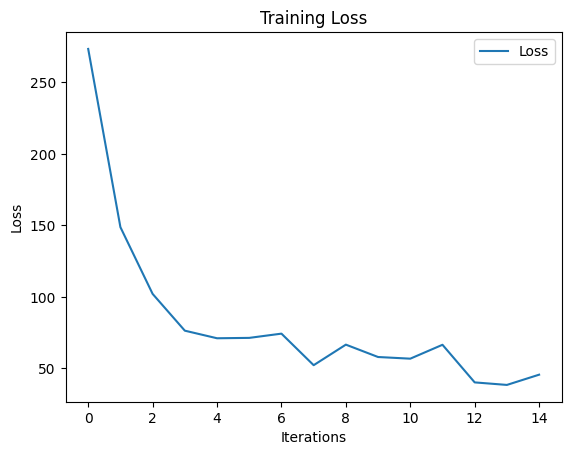

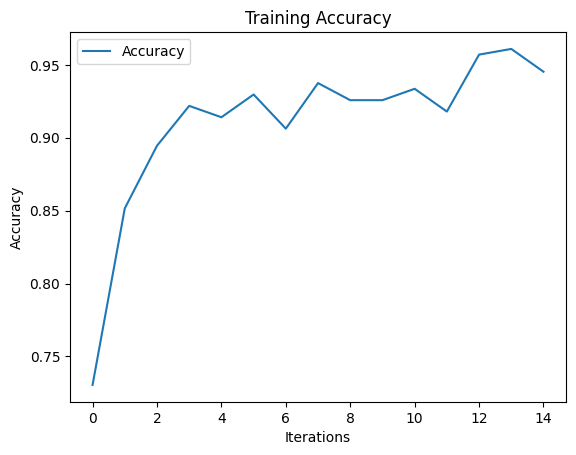

In [45]:
import matplotlib.pyplot as plt

# Графік функції втрат
plt.plot(loss_history, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Графік точності
plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [46]:
# Точність навченої нейромережі
test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.9391000270843506


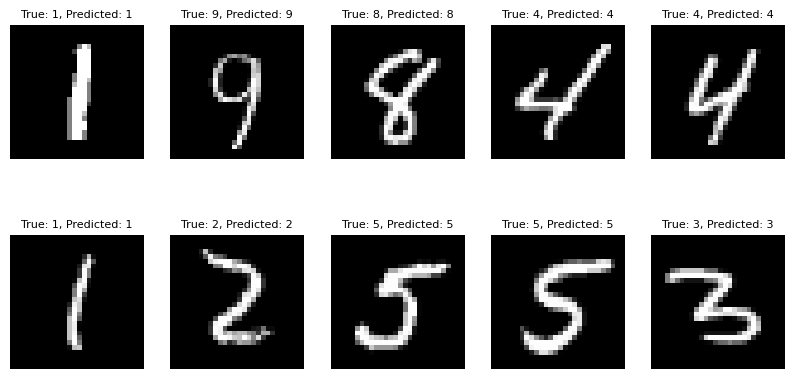

In [49]:
num_test_images = 10
random_indices = np.random.choice(len(x_test), num_test_images, replace=False)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1)

plt.figure(figsize=(10, 5))
for i in range(num_test_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.reshape(test_images[i], (28, 28)), cmap='gray')
    plt.title(f"True: {test_labels[i]}, Predicted: {predicted_labels[i]}", fontsize=8)
    plt.axis('off')
plt.show()

In [50]:
from sklearn.metrics import classification_report

predicted_classes = tf.argmax(neural_net(x_test), axis=1)

print(classification_report(y_test, predicted_classes, zero_division='warn'))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.94      0.94      0.94      1032
           3       0.93      0.92      0.93      1010
           4       0.95      0.94      0.95       982
           5       0.89      0.92      0.91       892
           6       0.95      0.96      0.95       958
           7       0.93      0.94      0.94      1028
           8       0.93      0.90      0.91       974
           9       0.93      0.92      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

